In [2]:
%%capture
from jupyterthemes import jtplot
jtplot.style()
import numpy as np
from landlab import FieldError
from landlab.utils import get_watershed_mask
import xarray as xr
import pandas as pd
import scipy
import gdal
from scipy import ndimage
from scipy.ndimage.filters import *
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
%matplotlib inline
import random
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
from landlab.plot.imshow import imshow_grid 
# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import FlowAccumulator, FlowRouter, LakeMapperBarnes, SinkFillerBarnes
from landlab.components import(FlowDirectorD8, 
                               FlowDirectorDINF, 
                               FlowDirectorMFD, 
                               FlowDirectorSteepest)
from landlab.components import DepressionFinderAndRouter
# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from pylab import show, figure

# create a plotting routine to make a 3d plot of our surface. 
def surf_plot(mg, surface='topographic__elevation', 
              title='Surface plot of topography', colormap = cm.gray):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    Z = (mg.at_node[surface].reshape(mg.shape))#[y1:y2, x1:x2]
    color = colormap((Z-Z.min())/(Z.max()-Z.min()))
    surf = ax.plot_surface(mg.node_x.reshape(mg.shape),#[y1:y2, x1:x2]
                           mg.node_y.reshape(mg.shape),#[y1:y2, x1:x2]
                           Z,
                           rstride=1, cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False)
    ax.view_init(elev=35, azim=-120)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    plt.show()

In [30]:
level_of_generalisation = 6
location = (r'C:/PhD/junk')
os.chdir(location)
input_geotiff = gdal.Open('fann_2013_1ma.tif')
initial_resolution = 1
x = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
input_DEM = x[1500:2000, 2000:3000]

input_outlets = gdal.Open('gully_1_a.tif')
initial_resolution = 1
o = np.array(input_outlets.GetRasterBand(1).ReadAsArray())
outlets = o[1500:2000, 2000:3000]

In [42]:
np.amax(find_outlet_id)

322480

In [37]:
node_grid = np.array(mg.nodes.reshape(mg.shape))

In [41]:
find_outlet_id = node_grid * outlets

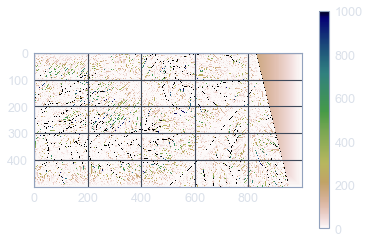

In [35]:
plt.imshow(drainage_area, cmap="gist_earth_r", vmax = 1000)
plt.colorbar()

In [5]:
from landlab.io import read_esri_ascii
(grid_bijou, z_bijou) = read_esri_ascii('west_bijou.txt', halo=1)

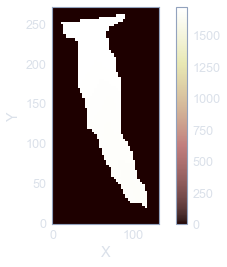

In [6]:
imshow_grid(grid_bijou, z_bijou)

In [7]:
grid_bijou.set_watershed_boundary_condition(z_bijou, 0)

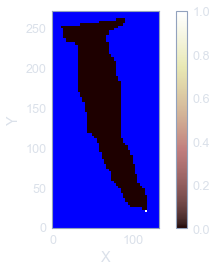

In [8]:
imshow_grid(grid_bijou, grid_bijou.status_at_node, color_for_closed='blue')

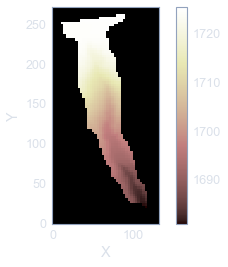

In [9]:
imshow_grid(grid_bijou, z_bijou)

In [10]:
mg1 = RasterModelGrid((5,5), 1.)
z1 = mg1.add_ones('node','topographic__elevation')
mg1.at_node['topographic__elevation'][2] = 0.
mg1.at_node['topographic__elevation']

array([ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [11]:
mg1.status_at_node

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1], dtype=uint8)

In [12]:
mg1.set_watershed_boundary_condition(z1)

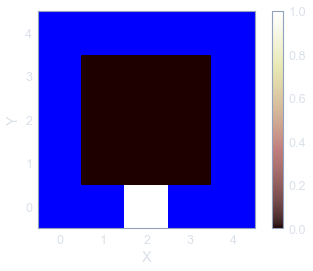

In [13]:
imshow_grid(mg1, mg1.status_at_node, color_for_closed='blue')

In [21]:
rmg = RasterModelGrid((7, 7))
z = np.array([
 -9999., -9999., -9999., -9999., -9999., -9999., -9999.,
 -9999.,    26.,     0.,    30.,    32.,    34., -9999.,
 -9999.,    28.,     1.,    25.,    28.,    32., -9999.,
-9999.,    30.,     3.,     3.,    11.,    34., -9999.,
-9999.,    32.,    11.,    25.,    18.,    38., -9999.,
-9999.,    34.,    32.,    34.,    36.,    40., -9999.,
-9999., -9999., -9999., -9999., -9999., -9999., -9999.])
rmg.at_node['topographic__elevation'] = z
rmg.set_closed_boundaries_at_grid_edges(True, True, True, False)
rmg.set_fixed_value_boundaries_at_grid_edges(False, False, False, True)
fr = FlowAccumulator(rmg, flow_director='D8')
fr.run_one_step()
# The second argument '2' here is the outlet_id.
ws = get_watershed_mask(rmg, 2).reshape(rmg.shape)
rmg.at_node['topographic__elevation']
wse = np.array(rmg.at_node['topographic__elevation']).reshape(7,7);
ns = np.array(rmg.status_at_node).reshape(7,7);


In [22]:
t = np.array(get_watershed_mask(rmg, 2).reshape(rmg.shape).astype(int));

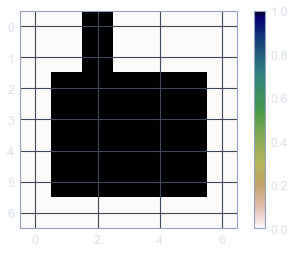

In [24]:
plt.imshow(t, cmap="gist_earth_r");
plt.colorbar();

In [25]:
flow_acc_surf = np.copy(input_DEM).astype('float64');
rows = flow_acc_surf.shape[0];
cols = flow_acc_surf.shape[1];
mg = RasterModelGrid((rows,cols), 1);
z1 = mg.add_field('topographic__elevation', flow_acc_surf, at = 'node');

In [26]:
mg = RasterModelGrid((flow_acc_surf.shape[0],flow_acc_surf.shape[1]), spacing=(1, 1));
mg.add_field('topographic__elevation', flow_acc_surf, at = 'node')
sfb = SinkFillerBarnes(mg, method = 'Steepest', ignore_overfill = True);
sfb.run_one_step();
fr = FlowAccumulator(mg, flow_director='D8')
fr.run_one_step()
# The second argument '68325' here is the outlet_id.


In [27]:
da = np.array(mg.at_node['drainage_area'].round(4))
frn = mg.at_node['flow__receiver_node']
drainage_area = da.reshape(mg.shape).astype('float64');
grid_nodes = (mg.nodes).reshape(mg.shape[0] * mg.shape[1],)
flow_rec_surf_rows = cols * rows;

In [38]:
find_gn = np.flip(mg.nodes, 0)

In [48]:
outlet_ids = mg.nodes * outlets

In [54]:
np.unique(find_outlet_id)

array([     0, 321480, 322480])

In [55]:
ws = np.array(get_watershed_mask(mg, 322480).reshape(mg.shape).astype(int))

In [56]:
test = ws * drainage_area

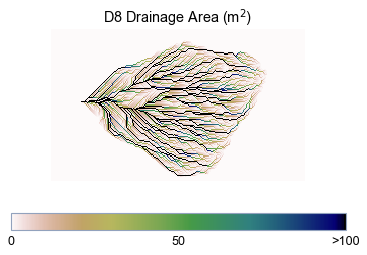

In [82]:
fig, ax = plt.subplots()

cax = ax.imshow(test[250:400, 450:700], interpolation='nearest', cmap='gist_earth_r', vmax = 100)
ax.set_title('D8 Drainage Area (m$^2$)', color = 'Black')

cbar = fig.colorbar(cax, ticks=[0, 50, 100], orientation='horizontal')
cbar.ax.set_xticklabels(['0', '50', '>100'], color = 'Black')  # horizontal colorbar
plt.axis('off')
plt.show()

In [21]:
size = test.shape[0] * test.shape[1]

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.


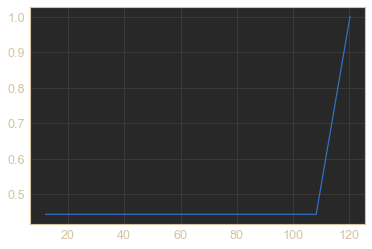

In [40]:
H, X1 = np.histogram(test, bins = 10, normed = True)
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
#X2 = np.sort(Z)
#F2 = np.array(range(size))/float(size)
plt.plot(X1[1:], F1)
#plt.plot(X2, F2)
plt.show()

In [35]:
Z

array([-0.96119989,  0.68232372, -0.22551923, -0.77419223, -0.36740789,
        0.02495255,  1.12545006,  0.86586545,  1.43777025,  0.076757  ,
       -1.4879505 ,  1.02971957, -1.29535439,  1.35231449, -1.29718016,
        0.11890285,  1.84451961, -1.46579456, -0.70093405, -0.41997036,
       -0.17032342, -0.29436037, -0.33983488, -1.38974183,  1.20870603,
        0.4730613 , -1.62914327,  0.80251367, -0.88197466,  0.20206666,
       -1.17642362, -1.01012926,  0.80372217, -0.89261344, -0.34782812,
        1.87735907,  1.7094689 , -0.19559355,  1.66362131, -1.30890175,
        0.42194125,  0.35249736,  0.49282716,  0.57323147,  1.41589263,
        0.87600606, -0.06092408, -0.73192219,  0.62952789,  0.23062807,
        0.02906582, -0.29298138,  0.44728224,  0.67243163, -1.11076856,
       -1.49512317,  0.89285568,  0.41838284, -2.5240369 ,  0.62578579,
       -2.21360004,  2.20036327, -0.04275914,  0.04204237, -0.13959046,
       -0.67739376,  1.39064104,  0.72835125, -0.21058311, -0.68